In [68]:
# <editor-fold desc="making df">
import pandas as pd
import numpy as np
#import pandas as pd
import os
from sklearn.model_selection import train_test_split
#uploaded = files.upload()
#then change the filepath buffer once the file is in google.colab. also remove the file.upload() function

#name the column, adding informative names to features
#data has no header, and no footheader
#train= pd.merge(pd.read_csv('/content/test_features.csv'), pd.read_csv('/content/train_labels.csv'))
train_label_df = pd.merge(pd.read_csv('../m2w2 kaggle/train_features.csv'),  pd.read_csv('../m2w2 kaggle/train_labels.csv'))
#label =pd.read_csv('/content/train_labels.csv')
#train= pd.read_csv('/content/train_features.csv')
test_df = pd.read_csv('../m2w2 kaggle/test_features.csv')
submission_df = pd.read_csv('../m2w2 kaggle/sample_submission.csv')
# </editor-fold>


In [38]:
train_label_df.head(2)

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


In [69]:
# <editor-fold desc="train, test, split">
from sklearn.model_selection import train_test_split
#Let Train, Validate, test then set features,target on .75 .25
train, validate = train_test_split(train_label_df, train_size = 0.75, test_size =0.25, random_state=42)
train.shape, validate.shape, test_df.shape
#I am using whole test_df to test. so let reword test_df to simply test
test = test_df
train.shape, validate.shape, test.shape
# </editor-fold>


((44550, 41), (14850, 41), (14358, 40))

In [70]:
# <editor-fold desc="wrangle function">
import numpy as np
def wrangle(X):
  #I will set boundries latitude (25,33), longitude (-14, 0)
  X=X.copy()
  #use number inbetween Long(25,44)   Lat (-14,0)     # can also use the replace method. many ways to do this.
  ###############################################################################
  #mask = ((X['longitude'] >= 22) & (X['longitude']<=44)) | ((X['latitude'] >= 1) & (X['latitude']<=-20))
  #X = X.loc[mask]
  ######################################################################
  X['latitude'] = X['latitude'].replace(-2e-08, 0)
    
    # When columns have zeros and shouldn't, they are like null values.
    # So we will replace the zeros with nulls, and impute missing values later.
  cols_with_zeros = ['longitude', 'latitude']
  for col in cols_with_zeros:
    X[col] = X[col].replace(0, np.nan)
  #rename 'status_group'
  X = X.rename(columns={'status_group':'status'})

  #Filter the dataframe with columns that has _group or _type in the syntax, then only list these columns.
  #Then Drop them because columns with _group or _type are duplicate of the original name that doesn't have those substring
  X = X.drop(X.filter(regex='_group').columns, axis=1)
  X = X.drop(X.filter(regex='_type').columns, axis=1)

  X = X.drop(columns=['basin', 'region', 'public_meeting', 'recorded_by', 'scheme_management', 'permit', 'management','quantity'])
  return X
# </editor-fold>

In [71]:
# <editor-fold desc="using wrangle function">
train = wrangle(train)
validate = wrangle(validate)
test = wrangle(test)
# </editor-fold>


In [42]:
# <editor-fold desc="target - features">
target = 'status'

train_features = train.drop(columns=[target,'id'])
#In the dataframe, grab all the numeric columns, then list it into columns. Finally turn it into array.
numeric_features = train_features.select_dtypes(include='number').columns.tolist()
#This (not a number) columns has how many unique categories?
cardinality = train_features.select_dtypes(exclude='number').nunique()
#if this columns has less than 50 keep that column, and turn it into array. (important step for panda ARRAY)
categorical_features = cardinality[cardinality <= 50].index.tolist()
#combine the list
features = numeric_features + categorical_features

# </editor-fold>

In [43]:
# <editor-fold desc="X-y train, X-y Validtae, test">
X_train = train[features]
y_train = train[target]

X_validate = train[features]
y_validate = train[target]

X_test = test[features]
# </editor-fold>


In [44]:
# <editor-fold desc="OneHot, SelectKbest,Ridge">
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import category_encoders as ce
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import Ridge # add penalty equivalent to square of the magnitude of the coefficients
#So ridge regression puts constraint on the coefficients
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score


pipeline_Gridsearch_Randomized = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    StandardScaler(),
    SelectKBest(f_regression),
    Ridge()
)
#search will randomly select n_iter from this universe over cv=5 (times).
param_distributions = {
    'simpleimputer__strategy' : ['mean','median'],
    'selectkbest__k' : range(1, len(X_train.columns)+1),
    'ridge__alpha': [0.1,1,10],
}
search = RandomizedSearchCV(
    pipeline_Gridsearch_Randomized,
    param_distributions=param_distributions,
    n_iter=30,
    cv=5,
    verbose=2,
    return_train_score=False,
    n_jobs=-1
)
# </editor-fold>
#search.fit(X_train, y_train);


In [45]:
# <editor-fold desc="Target encoder, SimpleImputer for numericals VALUES">
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import randint, uniform
from sklearn.ensemble import RandomForestRegressor
pipeline_TargetEncode_RandomForest = make_pipeline(
    ce.TargetEncoder(),
    SimpleImputer(),
    RandomForestRegressor(random_state=42)
)

param_distributions_Target_RandomForest = {
    'targetencoder__min_samples_leaf' : randint(1,1000),
    'targetencoder__smoothing' : uniform(1,1000),
    'simpleimputer__strategy': ['mean', 'median'],
    'randomforestregressor__n_estimators' : randint(50,500),
    'randomforestregressor__max_depth':[5,10,15,20,None],
    'randomforestregressor__max_features': uniform(0,1),
}
#multi_class='auto',solver='lbfgs',cv=5,n_jobs=-1
search_Target_random = RandomizedSearchCV(
    pipeline_TargetEncode_RandomForest,
    param_distributions=param_distributions_Target_RandomForest,
    n_iter=10,
    cv=3,
    scoring="neg_mean_absolute_error" ,
    verbose=10,
    return_train_score=True,
    n_jobs=-1
)
# </editor-fold>

In [46]:
# <editor-fold desc="OneHotencodr, Selectkbest, Ridge">
import category_encoders as ce
import numpy as np
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score


pipeline_OneHot_KBest_Ridge = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='mean'),
    StandardScaler(),
    SelectKBest(f_regression, k=20),
    Ridge(alpha=1.0)
)
#k=3
#scores = accuracy_score( pipeline_OneHot_KBest_Ridge, X_train, y_train)
# </editor-fold>

In [47]:
# <editor-fold desc="OneHot, SelectKbest,Ridge">
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import category_encoders as ce
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import Ridge # add penalty equivalent to square of the magnitude of the coefficients
#So ridge regression puts constraint on the coefficients
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score


pipeline_Gridsearch_Randomized = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    StandardScaler(),
    SelectKBest(f_regression),
    Ridge()
)
#search will randomly select n_iter from this universe over cv=5 (times).
param_distributions = {
    'simpleimputer__strategy' : ['mean','median'],
    'selectkbest__k' : range(1, len(X_train.columns)+1),
    'ridge__alpha': [0.1,1,10],
}
search = RandomizedSearchCV(
    pipeline_Gridsearch_Randomized,
    param_distributions=param_distributions,
    n_iter=30,
    cv=5,
    verbose=2,
    return_train_score=False,
    n_jobs=-1
)
# </editor-fold>


In [52]:

# <editor-fold desc="ordinal, selectkbest and ridge for numerica">
import category_encoders as ce
from sklearn.feature_selection import SelectKBest, f_classif


pipeline_OrdinalEncoder_selectKBestCata = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(),
    StandardScaler(),
    SelectKBest(f_classif, k=10),
    Ridge()
)
#search will randomly select n_iter from this universe over cv=5 (times).
param_distributions_ordinal_CataSelectKBest = {
    'simpleimputer__strategy' : ['mean','median'],
    'selectkbest__k' : range(1, len(X_train.columns)+1),
    'ridge__alpha': [0.1,1,10],
}
search_OrdinalEncoder_SelectKBestCata = RandomizedSearchCV(
    pipeline_OrdinalEncoder_selectKBestCata,
    param_distributions=param_distributions_ordinal_CataSelectKBest,
    n_iter=30,
    cv=5,
    verbose=10,
    scoring='neg_mean_absolute_error',
    return_train_score=True,
    n_jobs=-1
)
# </editor-fold>

In [109]:
# <editor-fold desc="#################Randomized search for Ordinal and random forest classifer############">
from scipy.stats import randint,uniform
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
import category_encoders as ce
from sklearn.pipeline import make_pipeline

pipeline_ordinal_RandomForestClassifier = make_pipeline(
    ce.OrdinalEncoder(), #
    SimpleImputer(strategy='mean'), #nan = mean
    RandomForestClassifier(n_estimators=5, random_state=42, n_jobs=-1) # more votes being cast if i increase n_estimators
)#n_estimator is how many trees. 

param_distributions_Ordinal_RandomForestclassifier = {
    'simpleimputer__stategy': 'mean',
    'randomforestclassifier__n_estimators': 100, #this is range(1,len(X_train.columns))
    'randomforestclassifier__max_depth': 5,
}

search_Ordinal_randomForestClassifer = RandomizedSearchCV(
    pipeline_ordinal_RandomForestClassifier,
    param_distributions=param_distributions_Ordinal_RandomForestclassifier,
    n_iter=20,
    cv=5,
    scoring='accuracy',
    verbose=10,
    return_train_score=True,
    n_jobs=-1
)
# </editor-fold>

In [113]:
# <editor-fold desc="###################Ordinal RandomForestclassifier,  randomizedSerachRv###################################">
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='mean'), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

param_dist ={
    'simpleimputer__strategy': ['mean', 'median'],
    'randomforestclassifier__n_estimators': randint(50,500),
    'randomforestclassifier__max_depth': [5,10,15,20,None],
    'randomforestclassifier__max_features': uniform(0,1),   
}

search_RFClassifer = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    n_iter=5,
    cv=3,
    verbose=10,
    scoring='accuracy',
    return_train_score=True,
    n_jobs=-1
)
# </editor-fold>

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  15 | elapsed:   26.8s remaining:  2.9min
[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:   28.2s remaining:  1.3min
[Parallel(n_jobs=-1)]: Done   6 out of  15 | elapsed:   31.2s remaining:   46.8s
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:   32.2s remaining:   28.2s
[Parallel(n_jobs=-1)]: Done  10 out of  15 | elapsed:   35.7s remaining:   17.8s
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:   36.5s remaining:    9.1s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   37.0s finished


In [134]:
# Fit on train, score on val
search_RFClassifer.fit(X_train, y_train)
score = search_RFClassifer.score(X_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  15 | elapsed:   19.3s remaining:  2.1min
[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:   20.7s remaining:   57.2s
[Parallel(n_jobs=-1)]: Done   6 out of  15 | elapsed:   20.9s remaining:   31.3s
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:   21.0s remaining:   18.3s
[Parallel(n_jobs=-1)]: Done  10 out of  15 | elapsed:   21.9s remaining:   10.9s
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:   23.6s remaining:    5.8s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   23.7s finished


In [117]:
# <editor-fold desc="learnHowTOSubmit">
#y_pred = search_RFClassifer.predict(X_test)
#submission_df['status_group']=y_pred
#submission_df.to_csv('submission_ten_ten.csv', index=False)
# </editor-fold>

In [151]:
#confusion matrix only work with catagory data?

validate_for_matrixthrowaway, validate_for_matrix = train_test_split(y_validate, test_size=len(test), stratify=train[target], random_state=42)
from sklearn.metrics import confusion_matrix
y_prediction_RFCCLassifier = search_RFClassifer.predict(X_test)

confusion_matrix(validate_for_matrix,y_prediction_RFCCLassifier)
#let make this confusion matrix easier to read.

array([[4617,  375, 2795],
       [ 632,   42,  371],
       [3268,  232, 2026]], dtype=int64)

let make the ugly matrix better.
let make this confusion matrix easier to read.
1)Labels - look at the array, then copy each unique string.
now assign the label to the column and index using a list comprehension. using for loop and adding in extra string
use a for loop, on the assign variable = unique_labels to print out [f' {}' for .... in ....]
now make a panda Dataframe table variable, use the confusion_matrix, literally pass this in 
 such that table has the Y_true on Ith, y_pred on jth.
use columns and index to assign the ith columns and jth row names. 
we have a nice table. put it into a sns.heatmap
annot =True, put number in heat map
fmt='d' - put into decimal 
cmap='viridia' = color code the matrix

In [161]:
import seaborn as sns
from sklearn.utils.multiclass import unique_labels
Label = unique_labels(validate_for_matrix) 
columns = [f'Actual {labels}' for labels in Label]
rows = [f'predicted {labels}' for labels in Label]
table = pd.DataFrame(confusion_matrix(validate_for_matrix,y_prediction_RFCCLassifier), columns=columns,
                     index=rows)

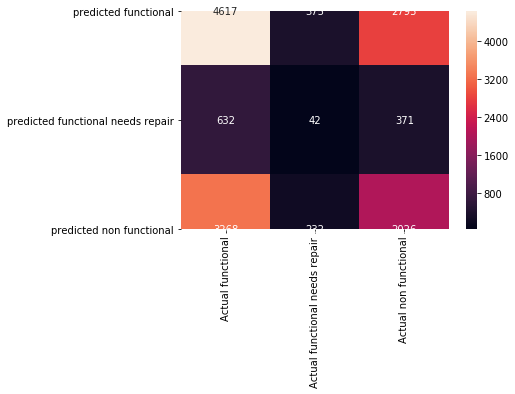

In [164]:
sns.heatmap(table, annot=True, fmt='d')

In [ ]:
print('precision - 81% of the time we were absolute right. that this water pump is functional, need repair, or not.')
print('recall - is like is should be true, but we HUMAN IDENTIFY it as false.')
print('how many correct predictions of non-functional?',  4017)
print('how many total predictions of non-functional', 3268+232+2026 )
print('what the precision of non-functional?', 2026/(3268+232+2026))
print('how many actual non-functional waterpumps?', (2026+371+2795))
print('what the recall for non-functional',2026/(3268+232+2026))

